### ENTRENAMIENTO DEL MODELO STUDENT MOBILENETV3 SMALL

Importar Librerias necesarias

In [1]:
import os
import numpy as np
import torchvision  
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle

import torch
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets

from timm import create_model
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

import timm  # Library con modelos SOTA, incluidos ViT
import time, copy
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import mobilenet_v3_small
import torch.nn.functional as F
import copy
import time
from tqdm import tqdm
import pickle

#Funciones generales para analizar resultados y m√©tricas
from src.eval_utils import visualizar_curvas, evaluar_modelo, medir_inferencia


C:\Users\Raider\AppData\Roaming\Python\Python39\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### ETAPA 1 PREPROCESAMIENTO, APLICACI√ìN DE T√âCNICAS - TRANSFORMERS

In [5]:
#Especificar el dispositivo para el entorno de trabajo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### Funciones adicionales utlizadas como t√©cnicas para mejorar la generalizaci√≥n
(Nota: estas funciones se las utiliz√≥ como parte de las pruebas, no usadas para el modelo final PILGaussianBlur, Cutout)

In [6]:
#ULTIMA MODIFICACION PARA MEJORAR LA GENERALIZACION (U1)
from PIL import ImageFilter
import random
import numpy as np
import torch

# Filtro de desenfoque Gaussiano (suaviza detalles irrelevantes)
class PILGaussianBlur:
    def __init__(self, radius=1.2):
        self.radius = radius
    def __call__(self, img):
        return img.filter(ImageFilter.GaussianBlur(self.radius))

# Cutout: elimina una regi√≥n cuadrada aleatoria
class Cutout:
    def __init__(self, mask_size=40, p=0.5, replace=0):
        self.mask_size = mask_size
        self.p = p
        self.replace = replace

    def __call__(self, img):
        if random.uniform(0, 1) > self.p:
            return img

        h, w = img.shape[1], img.shape[2]
        y = random.randint(0, h)
        x = random.randint(0, w)

        y1 = np.clip(y - self.mask_size // 2, 0, h)
        y2 = np.clip(y + self.mask_size // 2, 0, h)
        x1 = np.clip(x - self.mask_size // 2, 0, w)
        x2 = np.clip(x + self.mask_size // 2, 0, w)

        img[:, y1:y2, x1:x2] = self.replace
        return img


#### Preprocesamiento
Definir rutas y transformaciones, se define las t√©cnicas que seran aplicadas para el entrenamiento , con la finalidad de que el modelo generalice, evitar un sobreajuste, y consusi√≥n entre clases. (El transform definido en el siguiente bloque se lo utiliz√≥n para todos los casos de entrenamiento excepto el final que incorpora una Configuraci√≥n y SPLIT 80/15/5 reproducible)

In [7]:
# Ruta al dataset
data_path = 'TFM/food-101/food-101/images/'
# Clase para a√±adir ruido gaussiano
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=0.05):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        return tensor + torch.randn_like(tensor) * self.std + self.mean
        
# Transformaciones con t√©cnicas avanzadas de data augmentation
transform_train = transforms.Compose([
    #PILGaussianBlur(radius=1.2),  # Suavizado previo, AUMENTADO POR U1
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.3),    
    transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.3, 1.0)),  # ‚Üê APLICAR DESENFOQUE
    transforms.ToTensor(),
    #AddGaussianNoise(0., 0.05),
    #Cutout(mask_size=40, p=0.5),  # Regularizaci√≥n, , AUMENTADO POR U1
    #transforms.RandomErasing(p=0.2), #Aplicacion inicial
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.33), ratio=(0.3, 3.3)),  # ‚Üê BORRAR ALEATORIAMENTE cambio por cutmix
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

##### PARTICI√ìN DE DATOS
Partici√≥n del conjuntode datos inicialmente 70/15/15 configuraci√≥n t√≠pica, posterior se aplica 80/15/5:

Validaci√≥n: para afinar hiperpar√°metros, evitar overfitting (durante el entrenamiento).

Test: para evaluaci√≥n final, como si el modelo nunca hubiera visto esos datos.

In [8]:
# Dataset original con transformaciones de entrenamiento
full_dataset = datasets.ImageFolder(root=data_path, transform=transform_train)

# Divisi√≥n 70% train, 15% val, 15% test
total_size = len(full_dataset)
train_size = int(0.80 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size]
)

# Aplicar Transformaciones para val y test
val_dataset.dataset.transform = transform_val
test_dataset.dataset.transform = transform_val

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Clases
class_names = full_dataset.classes
print("Clases:", class_names)
print("Tamalo Clases:", len(class_names))

Clases: ['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', '

In [9]:
# Diccionario de dataloaders y tama√±os
dataloaders = {'train': train_loader, 'val': val_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

Visualizar algunas im√°genes con las t√©cnicas aplicadas (transformers)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.55038965..1.82].


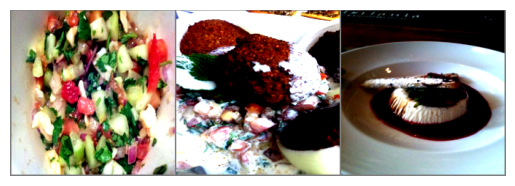

Etiquetas: ['ceviche', 'falafel', 'panna_cotta']


In [10]:
def imshow(img):
    img = img / 2 + 0.5  # desnormalizar
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Mostrar una tanda de im√°genes
dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:3]))
print('Etiquetas:', [class_names[i] for i in labels[:3]])

Visualizar distribuci√≥n de clases y algunas im√°genes

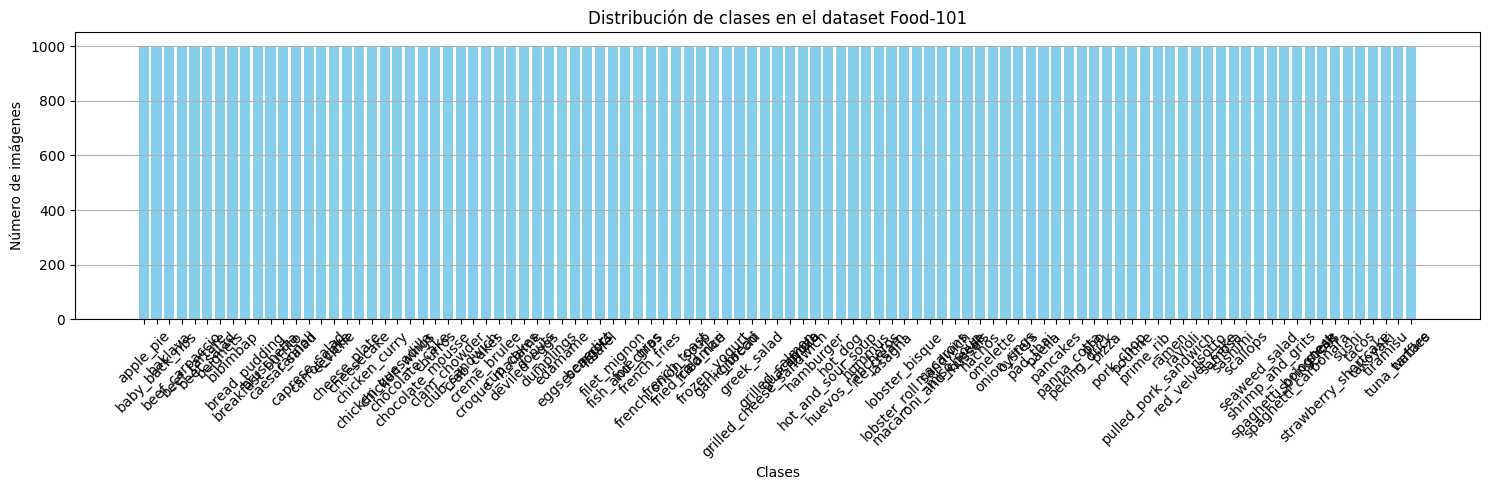

In [12]:
import os
import matplotlib.pyplot as plt
from collections import Counter
from PIL import Image

# Ruta a tus datos
dataset_path = data_path

# Obtener clases y conteo por clase
classes = os.listdir(dataset_path)
class_counts = {cls: len(os.listdir(os.path.join(dataset_path, cls))) for cls in classes}
class_counts = dict(sorted(class_counts.items(), key=lambda x: x[0]))  # Orden alfab√©tico

# Plot de barras: distribuci√≥n de clases
plt.figure(figsize=(15,5))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.title("Distribuci√≥n de clases en el dataset Food-101")
plt.xlabel("Clases")
plt.ylabel("N√∫mero de im√°genes")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

Todas las clases tienen el mismo numero de muestras, no existe desbalanceo


Mostrar algunas im√°genes aleatorias de diferentes clases (ejemplificar im√°genes originales)

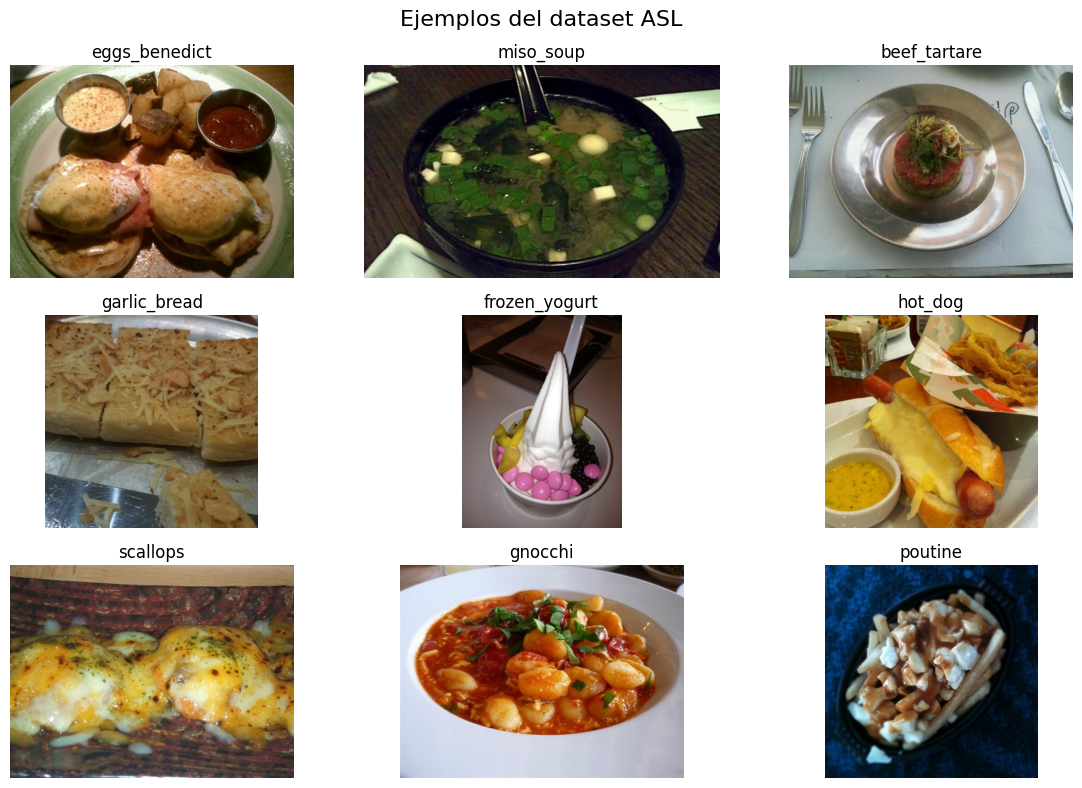

In [12]:
import random

plt.figure(figsize=(12, 8))

for i, cls in enumerate(random.sample(classes, 9)):
    cls_path = os.path.join(dataset_path, cls)
    img_name = random.choice(os.listdir(cls_path))
    img_path = os.path.join(cls_path, img_name)

    img = Image.open(img_path)

    plt.subplot(3, 3, i+1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis("off")

plt.suptitle("Ejemplos del dataset ASL", fontsize=16)
plt.tight_layout()
plt.show()

### ETAPA 2  Entrenamiento del Modelo Student (MobileNetV3 Small)

Con el fin de garantizar un punto de partida s√≥lido que permitiera evaluar su capacidad de generalizaci√≥n a partir de las configuraciones exitosas obtenidas con el modelo Teacher, se decidi√≥ reutilizar las mismas t√©cnicas de aumento de datos, regularizaci√≥n y particionado, asegurando as√≠ condiciones comparables y consistentes en la evaluaci√≥n de resultados.

La funci√≥n de entrenamiento se reutiliza la que se aplico en ViT Base que entrena el modelo aplicando **CutMix de forma probabil√≠stica** 

 Instalar y/o importar dependencias necesarias

In [11]:
#!pip install -q timm

from timm import create_model
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

import timm  # Library con modelos SOTA, incluidos ViT
import time, copy
import os


#### DEFINICI√ìN DEL MODELO STUDENT
Cargar e instanciar el modelo MobileNetV3 Small preentrenado

In [ ]:
#A. Carga del modelo Student (MobileNetV3 Small)
import torch
import torch.nn as nn
from torchvision.models import mobilenet_v3_small

# 101 clases dataset FOD-101
num_classes = len(class_names)

# Crear Modelo MobileNetV3 Small con pesos preentrenados
student_model = mobilenet_v3_small(pretrained=True)

# Reemplazar la capa final (classifier) por una con 101 clases
student_model.classifier[3] = nn.Linear(student_model.classifier[3].in_features, num_classes)

# Mover a GPU si est√° disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

student_model = student_model.to(device)


#### Funciones generales aplicadas en el entrenamiento

In [14]:
# Funci√≥n de entrenamiento con soporte a CutMix aplicando condicional con probabilidad
def train_model(model, criterion, optimizer, dataloaders, dataset_sizes, num_epochs=25, patience=5, scheduler=None, prob_cutmix=0.3):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    early_stop_counter = 0
    start_time = time.time()

    for epoch in range(num_epochs):
        print(f"\nüü¶ Epoch {epoch+1}/{num_epochs}")
        epoch_start_time = time.time()

        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                # Aplicar CutMix si corresponde
                if phase == 'train' and torch.rand(1).item() < prob_cutmix:
                    inputs, targets_a, targets_b, lam = cutmix_data(inputs, labels)
                else:
                    targets_a, targets_b, lam = labels, labels, 1.0

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)

                    if phase == 'train' and lam < 1.0:
                        loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)
                        _, preds = torch.max(outputs, 1)
                        corrects = lam * preds.eq(targets_a).sum().item() + (1 - lam) * preds.eq(targets_b).sum().item()
                    else:
                        loss = criterion(outputs, labels)
                        _, preds = torch.max(outputs, 1)
                        corrects = torch.sum(preds == labels.data).item()

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += corrects

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val':
                if scheduler:
                    scheduler.step(epoch_acc)
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    early_stop_counter = 0
                else:
                    early_stop_counter += 1

        epoch_duration = time.time() - epoch_start_time
        print(f"‚è≥ Tiempo de la √©poca {epoch+1}: {epoch_duration:.2f} segundos")

        if early_stop_counter >= patience:
            print("\n‚èπ Early stopping activado")
            break

    total_time = time.time() - start_time
    print(f'\nüü© Entrenamiento completo en {total_time // 60:.0f}m {total_time % 60:.0f}s')
    print(f'Mejor accuracy de validaci√≥n: {best_acc:.4f}')

    model.load_state_dict(best_model_wts)
    return model, history


In [13]:
# Clase para aplicar CutMix
import random
import numpy as np

def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

#Solo para vitabse mejora alpha=0.2 ahora alpha=0.3
def cutmix_data(x, y, alpha=0.3):
    indices = torch.randperm(x.size(0))
    shuffled_x = x[indices]
    shuffled_y = y[indices]

    lam = np.random.beta(alpha, alpha)
    bbx1, bby1, bbx2, bby2 = rand_bbox(x.size(), lam)
    x[:, :, bbx1:bbx2, bby1:bby2] = shuffled_x[:, :, bbx1:bbx2, bby1:bby2]

    y_a, y_b = y, shuffled_y
    return x, y_a, y_b, lam

#### ENTRENAMIENTOS


#### Caso 1: Entrenamiento desde cero o con fine-tuning

Entrenaremos MobileNetV3 Small desde cero o usando pesos preentrenados, adaptando la √∫ltima capa para la clasificaci√≥n de las 101 clases de FOD-101.

Entrenamiento estandar. En este primer caso se evalu√≥ el desempe√±o del modelo MobileNetV3 Small bajo un proceso de fine-tuning de 20 √©pocas, utilizando una partici√≥n del 80% para entrenamiento, 15% para validaci√≥n y 5% para prueba.


En el siguiente bloque se configuran los elementos principales para entrenar el **modelo Student (MobileNetV3 Small)**:  

- **Funci√≥n de p√©rdida (`criterion_student`)**: se utiliza `CrossEntropyLoss`, apropiada para problemas de clasificaci√≥n multiclase.  
- **Optimizador (`optimizer_student`)**: se emplea `Adam` con tasa de aprendizaje `1e-4`, encargado de ajustar los pesos del modelo.  
- **Scheduler (`scheduler_student`)**: `ReduceLROnPlateau` reduce el *learning rate* a la mitad si la **accuracy de validaci√≥n** no mejora en 3 √©pocas consecutivas, ayudando a refinar el aprendizaje y evitar estancamientos.  

Este bloque define la estrategia de optimizaci√≥n y control del entrenamiento del modelo Student.  


In [16]:
#B. Entrenamiento cl√°sico (CrossEntropy)
# Se reutiliza train_model() que ya fue definido para ViT Base
import time
import torch.optim as optim
from tqdm import tqdm

criterion_student = nn.CrossEntropyLoss()
optimizer_student = optim.Adam(student_model.parameters(), lr=1e-4)

scheduler_student = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_student,  # ‚úÖ Usa el optimizador del Student
    mode='max',         # Maximizar la accuracy
    factor=0.5,         # Reducir LR a la mitad si no mejora
    patience=3,         # Esperar 3 √©pocas sin mejora
    verbose=True
)


En siguiente bloque se lleva a cabo el **entrenamiento del modelo Student (MobileNetV3 Small)** utilizando la funci√≥n `train_model`, con un m√°ximo de 20 √©pocas, paciencia de 5 para early stopping y el scheduler previamente configurado.  

Al finalizar el entrenamiento:  
- Se **guarda el modelo entrenado** en el archivo `mobilenetv3_student_classic_food.pth`.  
- Se **almacena el historial de m√©tricas** (`train_loss`, `val_loss`, `train_acc`, `val_acc`) en `historial_student_classic_food.pkl`, lo que permite posteriormente **visualizar las curvas de entrenamiento y comparar su rendimiento con otros modelos**.  

In [ ]:
# Entrenar modelo 
student_model, history_student = train_model(
    student_model, criterion_student, optimizer_student,
    dataloaders, dataset_sizes, num_epochs=20,patience=5,scheduler=scheduler_student, , prob_cutmix = 0.5
)

# Guardar modelo entrenado cl√°sico
torch.save(student_model.state_dict(), 'mobilenetv3_student_classic_food.pth')

# Guardar el historial de m√©tricas (loss y accuracy por √©poca)  train_loss,val_loss, train_acc, val_acc
# Para Visualizar curvas de entrenamiento y Comparar modelos
with open("historial_student_classic_food.pkl", "wb") as f:
    pickle.dump(history_student, f)


Resultado Entrenamiento1 (Caso1):

üü¶ Epoch 1/20
train Loss: 2.2690 Acc: 0.4471
val Loss: 1.4821 Acc: 0.6139
‚è≥ Tiempo de la √©poca 1: 224.18 segundos

üü¶ Epoch 2/20
train Loss: 1.4808 Acc: 0.6109
val Loss: 1.3019 Acc: 0.6524
‚è≥ Tiempo de la √©poca 2: 120.93 segundos

üü¶ Epoch 3/20
train Loss: 1.2488 Acc: 0.6669
val Loss: 1.2232 Acc: 0.6774
‚è≥ Tiempo de la √©poca 3: 124.40 segundos

üü¶ Epoch 4/20
train Loss: 1.0934 Acc: 0.7040
val Loss: 1.2025 Acc: 0.6850
‚è≥ Tiempo de la √©poca 4: 121.42 segundos

üü¶ Epoch 5/20
train Loss: 0.9750 Acc: 0.7307
val Loss: 1.1737 Acc: 0.6945
‚è≥ Tiempo de la √©poca 5: 121.61 segundos

üü¶ Epoch 6/20
train Loss: 0.8715 Acc: 0.7572
val Loss: 1.1744 Acc: 0.7008
‚è≥ Tiempo de la √©poca 6: 121.16 segundos

üü¶ Epoch 7/20
train Loss: 0.7819 Acc: 0.7796
val Loss: 1.1633 Acc: 0.7038
‚è≥ Tiempo de la √©poca 7: 123.36 segundos

üü¶ Epoch 8/20
train Loss: 0.7062 Acc: 0.7976
val Loss: 1.2104 Acc: 0.7024
‚è≥ Tiempo de la √©poca 8: 124.52 segundos

üü¶ Epoch 9/20
train Loss: 0.6343 Acc: 0.8163
val Loss: 1.2078 Acc: 0.7021
‚è≥ Tiempo de la √©poca 9: 126.84 segundos

üü¶ Epoch 10/20
train Loss: 0.5708 Acc: 0.8304
val Loss: 1.2422 Acc: 0.7013
‚è≥ Tiempo de la √©poca 10: 131.65 segundos

üü¶ Epoch 11/20
train Loss: 0.5183 Acc: 0.8445
val Loss: 1.2967 Acc: 0.7015
‚è≥ Tiempo de la √©poca 11: 124.10 segundos

üü¶ Epoch 12/20
train Loss: 0.3918 Acc: 0.8815
val Loss: 1.3004 Acc: 0.7043
‚è≥ Tiempo de la √©poca 12: 124.74 segundos

üü¶ Epoch 13/20
train Loss: 0.3547 Acc: 0.8931
val Loss: 1.3307 Acc: 0.7007
‚è≥ Tiempo de la √©poca 13: 121.79 segundos

üü¶ Epoch 14/20
train Loss: 0.3244 Acc: 0.9016
val Loss: 1.3910 Acc: 0.6979
‚è≥ Tiempo de la √©poca 14: 123.49 segundos

üü¶ Epoch 15/20
train Loss: 0.3036 Acc: 0.9067
val Loss: 1.4127 Acc: 0.6975
‚è≥ Tiempo de la √©poca 15: 121.97 segundos

üü¶ Epoch 16/20
train Loss: 0.2810 Acc: 0.9135
val Loss: 1.4470 Acc: 0.6962
‚è≥ Tiempo de la √©poca 16: 121.86 segundos

üü¶ Epoch 17/20
train Loss: 0.2310 Acc: 0.9285
val Loss: 1.4571 Acc: 0.6964
‚è≥ Tiempo de la √©poca 17: 122.76 segundos

‚èπ Early stopping activado

üü© Entrenamiento completo en 36m 41s
Mejor accuracy de validaci√≥n: 0.7043



#### Caso 2:
Con el objetivo de evaluar el efecto de la t√©cnica CutMix, se ejecut√≥ un segundo experimento en el que esta fue removida, manteni√©ndose constantes el resto de configuraciones. El modelo se entren√≥ durante un m√°ximo de 30 √©pocas, bajo las mismas condiciones de particionado y t√©cnicas de regularizaci√≥n utilizadas previamente. Partici√≥n 80/15/5


Se mantiene la misma estrategia de optimizaci√≥n y control del entrenamiento del modelo Student.


In [ ]:
#B. Entrenamiento cl√°sico (CrossEntropy)
# Se reutiliza train_model() que ya fue definido para ViT Base
import time
import torch.optim as optim
from tqdm import tqdm

criterion_student = nn.CrossEntropyLoss()
optimizer_student = optim.Adam(student_model.parameters(), lr=1e-4)

scheduler_student = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_student,  # ‚úÖ Usa el optimizador del Student
    mode='max',         # Maximizar la accuracy
    factor=0.5,         # Reducir LR a la mitad si no mejora
    patience=3,         # Esperar 3 √©pocas sin mejora
    verbose=True
)


A continuaci√≥n se realiza el entrenamiento nuevamente el **modelo Student (MobileNetV3 Small)**, pero a diferencia del entrenamiento previo se **desactiva la t√©cnica CutMix** (`prob_cutmix=0.0`).  

El objetivo de esta configuraci√≥n es obtener un **modelo Student cl√°sico sin t√©cnicas adicionales de regularizaci√≥n**, lo que permite usarlo como referencia para evaluar despu√©s la **optimizaci√≥n mediante Knowledge Distillation (KD)**.  

Al finalizar el entrenamiento:  
- Se **guarda el modelo entrenado** en `mobilenetv3_student_classic_food.pth`.  
- Se **almacena el historial de m√©tricas** (`train_loss`, `val_loss`, `train_acc`, `val_acc`) en `historial_student_classic_food.pkl`, con el fin de **analizar las curvas de entrenamiento y compararlas contra el modelo optimizado con KD**.  



In [ ]:
# Entrenar modelo 
student_model, history_student = train_model(
    student_model, criterion_student, optimizer_student,
    dataloaders, dataset_sizes, num_epochs=20,patience=5,scheduler=scheduler_student, prob_cutmix = 0.0
)

# Guardar modelo entrenado cl√°sico
torch.save(student_model.state_dict(), 'mobilenetv3_student_classic_food.pth')

# Guardar el historial de m√©tricas (loss y accuracy por √©poca)  train_loss,val_loss, train_acc, val_acc
# Para Visualizar curvas de entrenamiento y Comparar modelos
with open("historial_student_classic_food.pkl", "wb") as f:
    pickle.dump(history_student, f)

Entrenamiento 1 Caso2

üü¶ Epoch 1/30 train Loss: 2.2585 Acc: 0.4494 val Loss: 1.5088 Acc: 0.6090 ‚è≥ Tiempo de la √©poca 1: 209.90 segundos 

üü¶ Epoch 2/30 train Loss: 1.4155 Acc: 0.6279 val Loss: 1.2946 Acc: 0.6610 ‚è≥ Tiempo de la √©poca 2: 123.76 segundos 

üü¶ Epoch 3/30 train Loss: 1.1841 Acc: 0.6836 val Loss: 1.2191 Acc: 0.6815 ‚è≥ Tiempo de la √©poca 3: 125.37 segundos 

üü¶ Epoch 4/30 train Loss: 1.0360 Acc: 0.7190 val Loss: 1.1654 Acc: 0.6943 ‚è≥ Tiempo de la √©poca 4: 125.07 segundos 

üü¶ Epoch 5/30 train Loss: 0.9107 Acc: 0.7494 val Loss: 1.1726 Acc: 0.6968 ‚è≥ Tiempo de la √©poca 5: 123.46 segundos 

üü¶ Epoch 6/30 train Loss: 0.8108 Acc: 0.7745 val Loss: 1.1698 Acc: 0.7031 ‚è≥ Tiempo de la √©poca 6: 123.81 segundos 

üü¶ Epoch 7/30 train Loss: 0.7264 Acc: 0.7953 val Loss: 1.1699 Acc: 0.7022 ‚è≥ Tiempo de la √©poca 7: 123.81 segundos 

üü¶ Epoch 8/30 train Loss: 0.6461 Acc: 0.8150 val Loss: 1.2086 Acc: 0.6986 ‚è≥ Tiempo de la √©poca 8: 123.72 segundos 

üü¶ Epoch 9/30 train Loss: 0.5745 Acc: 0.8330 val Loss: 1.2346 Acc: 0.7018 ‚è≥ Tiempo de la √©poca 9: 123.25 segundos

üü¶ Epoch 10/30 train Loss: 0.5137 Acc: 0.8484 val Loss: 1.2639 Acc: 0.7005 ‚è≥ Tiempo de la √©poca 10: 123.34 segundos 

üü¶ Epoch 11/30 train Loss: 0.3987 Acc: 0.8832 val Loss: 1.2897 Acc: 0.7026 ‚è≥ Tiempo de la √©poca 11: 123.94 segundos 

‚èπ Early stopping activado 

üü© Entrenamiento completo en 24m 9s Mejor accuracy de validaci√≥n: 0.7031


En este caso, la mejor precisi√≥n en validaci√≥n fue en la √©poca 6, con una p√©rdida de 1.1698. Sin embargo, el modelo mostr√≥ un patr√≥n claro de sobreajuste temprano.

#### Caso 3 (Final):
El entrenamiento se evalu√≥ una configuraci√≥n optimizada, con par√°metros refinados de CutMix y la aplicaci√≥n de las mejores t√©cnicas de aumento de datos. El entrenamiento se desarroll√≥ durante 50 √©pocas con una tasa de aprendizaje de 1e-4, optimizador AdamW y activaci√≥n de early stopping con paciencia de 10.
Partici√≥n de datos 80/15/5


Se mantiene la misma estrategia de optimizaci√≥n y control del entrenamiento del modelo Student.



#### Variaci√≥n Final en el entrenamiento del modelo

Con la finalidad de que la evaluaci√≥n de los resultados no sean variantes por la partici√≥n de datos tradicional, para la versi√≥n final se realiza una nueva partici√≥n conservando las mismas t√©cnicas, para asegurar que ser√° el mismo conjunto de datos para evaluar con respecto a los modelos Student con MobileNetV3 Small y con el modelo Student MobileNetV3 Smalll con KD se implmenta un SPLIT reproducible

In [ ]:
# =========================
# Configuraci√≥n y SPLIT 80/15/5 reproducible
# =========================
import os, json, random, numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

# Semillas para reproducibilidad total (entrenamiento y evaluaci√≥n)
seed = 42
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Ruta al dataset 
data_path = 'TFM/food-101/food-101/images/'


# =========================
# TRANSFORMS
# =========================
# Transformaciones de entrenamiento (data augmentation + normalizaci√≥n)
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.3),
    transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.3, 1.0)),
    transforms.ToTensor(),
    # AddGaussianNoise(0., 0.05),                    # ‚Üê activar solo si lo justificas
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.33), ratio=(0.3, 3.3)),  # regularizaci√≥n adicional, BORRAR ALEATORIAMENTE 
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Transform de validaci√≥n/test (sin aumentaci√≥n; √∫nicamente preprocesado)
transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# =========================
# SPLIT ESTRATIFICADO 80/15/5 (persistente)
# =========================
split_file = "splits_food101_80_15_5_stkd.json"

# Dataset auxiliar SOLO para mapear rutas->clase e √≠ndices (no se usa para entrenar)
_full_indexer = datasets.ImageFolder(root=data_path, transform=transform_val)
class_names = _full_indexer.classes  # ‚Üê mantiene tu variable
total_size = len(_full_indexer)

if os.path.exists(split_file):
    # Cargar √≠ndices guardados (garantiza mismo split en cada ejecuci√≥n)
    with open(split_file, "r") as f:
        idxs = json.load(f)
    train_idx = idxs["train"]
    val_idx   = idxs["val"]
    test_idx  = idxs["test"]
else:
    # Crear √≠ndices estratificados 80/15/5 y guardarlos
    labels_all = [lbl for _, lbl in _full_indexer.samples]
    all_idx = list(range(total_size))

    # 80% train vs 20% (val+test)
    train_idx, temp_idx, y_train, y_temp = train_test_split(
        all_idx, labels_all, test_size=0.20, stratify=labels_all, random_state=seed
    )
    # Del 20% restante ‚Üí 15% val y 5% test: 5/(15+5)=0.25
    val_idx, test_idx = train_test_split(
        temp_idx, test_size=0.25, stratify=[labels_all[i] for i in temp_idx], random_state=seed
    )
    with open(split_file, "w") as f:
        json.dump({"train": train_idx, "val": val_idx, "test": test_idx}, f)

# =========================
# DATASETS (separados por transform para evitar efectos colaterales)
# =========================
full_dataset = datasets.ImageFolder(root=data_path, transform=transform_train)

# Creamos dos bases: una con augment (train) y otra de evaluaci√≥n (val/test)
_dataset_train_tf = datasets.ImageFolder(root=data_path, transform=transform_train)
_dataset_eval_tf  = datasets.ImageFolder(root=data_path, transform=transform_val)

# Subsets con los √çNDICES FIJOS (reproducibles)
train_dataset = Subset(_dataset_train_tf, train_idx)
val_dataset   = Subset(_dataset_eval_tf,  val_idx)
test_dataset  = Subset(_dataset_eval_tf,  test_idx)

# =========================
# DATALOADERS
# =========================
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=32, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

# =========================
# METADATOS 
# =========================
dataloaders = {'train': train_loader, 'val': val_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

# Logging corto para verificar tama√±os
print(f"Total im√°genes: {total_size} | Train: {len(train_dataset)} | Val: {len(val_dataset)} | Test: {len(test_dataset)}")
print("Clases:", class_names)
print(f"Clases: {len(class_names)}")

Entrenar el modelo

En el siguiente bloque se realiza el **entrenamiento final del modelo Student (MobileNetV3 Small)**, utilizando la funci√≥n `train_model` previamente definida.  

Se configuran los componentes de entrenamiento:  
- **Funci√≥n de p√©rdida**: `CrossEntropyLoss`, adecuada para clasificaci√≥n multiclase.  
- **Optimizador**: `Adam` con `lr=1e-4`.  
- **Scheduler**: `ReduceLROnPlateau`, que reduce el *learning rate* si la accuracy de validaci√≥n no mejora tras 3 √©pocas consecutivas.  

El entrenamiento se ejecuta durante un m√°ximo de **50 √©pocas** con una **paciencia de 10** para early stopping, aplicando **CutMix con probabilidad de 0.3** para mejorar la generalizaci√≥n.  

Al finalizar:  
- El modelo se guarda en `mobilenetv3_student_classic_food3.pth`.  
- El historial de m√©tricas (`train_loss`, `val_loss`, `train_acc`, `val_acc`) se almacena en `historial_student_classic_food3.pkl`, lo que permite **analizar las curvas de entrenamiento y comparar este modelo final con otras variantes**.  
 

Este ajuste se considera como la **versi√≥n final y optimizada del modelo Student (MobileNetV3 Small)**.  


In [10]:
#B. Entrenamiento cl√°sico (CrossEntropy)
# Se reutiliza train_model() que ya fue definido para ViT Base
import time
import torch.optim as optim
from tqdm import tqdm

criterion_student = nn.CrossEntropyLoss()
optimizer_student = optim.Adam(student_model.parameters(), lr=1e-4)

scheduler_student = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_student,  # ‚úÖ Usa el optimizador del Student
    mode='max',         # Maximizar la accuracy
    factor=0.5,         # Reducir LR a la mitad si no mejora
    patience=3,         # Esperar 3 √©pocas sin mejora
    verbose=True
)

student_model, history_student = train_model(
    student_model, criterion_student, optimizer_student,
    dataloaders, dataset_sizes, num_epochs=50,patience=10,scheduler=scheduler_student, prob_cutmix = 0.3
)

# Guardar modelo entrenado cl√°sico
torch.save(student_model.state_dict(), 'mobilenetv3_student_classic_food3.pth')

# Guardar el historial de m√©tricas (loss y accuracy por √©poca)  train_loss,val_loss, train_acc, val_acc
# Para Visualizar curvas de entrenamiento y Comparar modelos
with open("historial_student_classic_food3.pkl", "wb") as f:
    pickle.dump(history_student, f)

####MODELO BUENO


C:\Users\Raider\AppData\Roaming\Python\Python39\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



üü¶ Epoch 1/50
train Loss: 2.3372 Acc: 0.4330
val Loss: 1.5468 Acc: 0.6028
‚è≥ Tiempo de la √©poca 1: 259.89 segundos

üü¶ Epoch 2/50
train Loss: 1.5271 Acc: 0.6018
val Loss: 1.3156 Acc: 0.6566
‚è≥ Tiempo de la √©poca 2: 169.11 segundos

üü¶ Epoch 3/50
train Loss: 1.3294 Acc: 0.6459
val Loss: 1.2235 Acc: 0.6780
‚è≥ Tiempo de la √©poca 3: 169.81 segundos

üü¶ Epoch 4/50
train Loss: 1.1937 Acc: 0.6795
val Loss: 1.1602 Acc: 0.6931
‚è≥ Tiempo de la √©poca 4: 173.12 segundos

üü¶ Epoch 5/50
train Loss: 1.0956 Acc: 0.7040
val Loss: 1.1376 Acc: 0.6993
‚è≥ Tiempo de la √©poca 5: 172.79 segundos

üü¶ Epoch 6/50
train Loss: 1.0169 Acc: 0.7211
val Loss: 1.1204 Acc: 0.7057
‚è≥ Tiempo de la √©poca 6: 175.36 segundos

üü¶ Epoch 7/50
train Loss: 0.9521 Acc: 0.7370
val Loss: 1.0799 Acc: 0.7136
‚è≥ Tiempo de la √©poca 7: 175.38 segundos

üü¶ Epoch 8/50
train Loss: 0.8899 Acc: 0.7542
val Loss: 1.0805 Acc: 0.7187
‚è≥ Tiempo de la √©poca 8: 191.37 segundos

üü¶ Epoch 9/50
train Loss: 0.8323 Acc:

### ETAPA 3
##### Curvas Loss, Accuracy en el entrenamiento.

##### Mostrar m√©tricas, evaluar el modelo

 Visualizaci√≥n de m√©tricas/ curvas

sTUDENT CLASICO


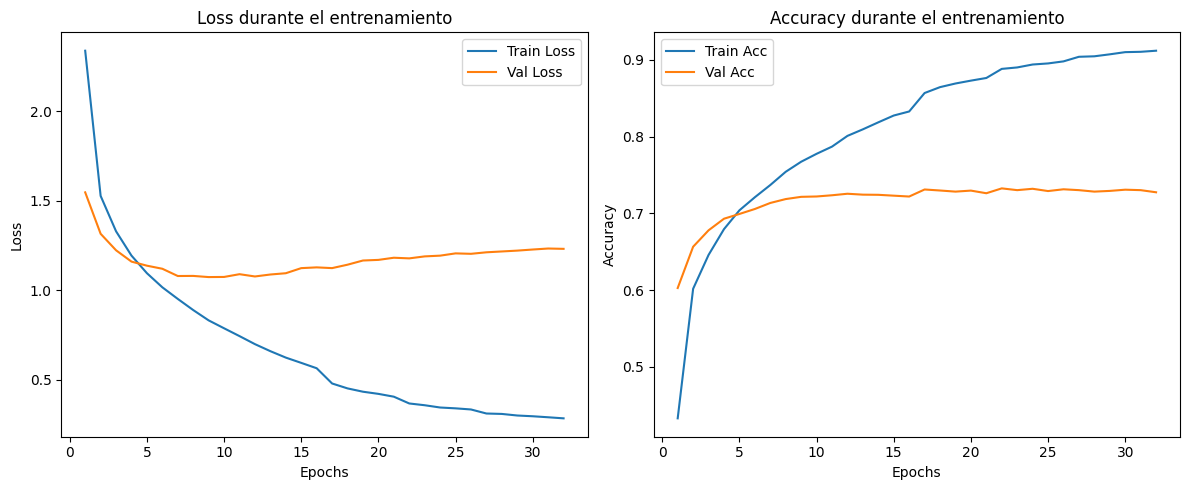

Tiempo inferencia Student
‚è±Ô∏è Tiempo de inferencia promedio por imagen: 8.895 ms


In [13]:
#sTUDENT CLASICO
with open("historial_student_classic_food3.pkl", "rb") as f:
    history_student = pickle.load(f)   

# Modelo Student
print('sTUDENT CLASICO')
visualizar_curvas(history_student)    

print('Tiempo inferencia Student')
tiempo_mobilenet = medir_inferencia(modelo_student_clasico, test_loader, device)

Visualizar m√©tricas adicionales, evaluaci√≥n del modelo y matriz de confusi√≥n

Evaluar modelo sTUDENT en test
üìä Clasification Report:
                         precision    recall  f1-score   support

              apple_pie       0.56      0.54      0.55        50
         baby_back_ribs       0.80      0.72      0.76        50
                baklava       0.80      0.86      0.83        50
         beef_carpaccio       0.77      0.74      0.76        50
           beef_tartare       0.63      0.74      0.68        50
             beet_salad       0.62      0.58      0.60        50
               beignets       0.85      0.78      0.81        50
               bibimbap       0.80      0.88      0.84        50
          bread_pudding       0.55      0.58      0.56        50
      breakfast_burrito       0.59      0.52      0.55        50
             bruschetta       0.68      0.60      0.64        50
           caesar_salad       0.77      0.80      0.78        50
                cannoli       0.80      0.74      0.77        50
          caprese_salad       0

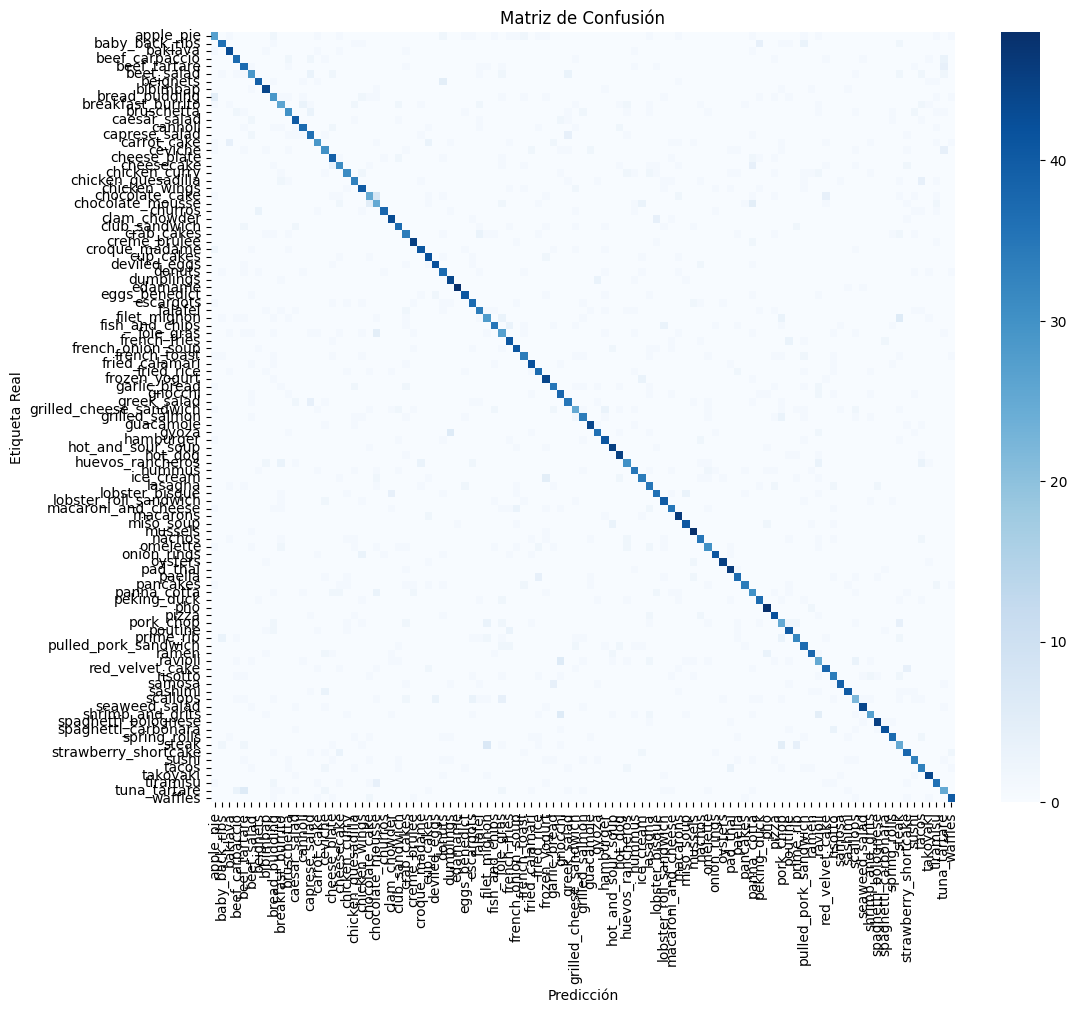

In [9]:
# Evaluar modelo sTUDENT en test
print('Evaluar modelo sTUDENT en test')
evaluar_modelo(modelo_student_clasico, test_loader, class_names, device)

### CONCLUSI√ìN ‚Äì Entrenamiento del modelo Student (MobileNetV3 Small, Caso 3)

Los resultados alcanzados en el entrenamiento final muestran las **limitaciones y fortalezas del modelo Student cl√°sico**.  
Las curvas de entrenamiento evidencian que, aunque la p√©rdida en entrenamiento disminuye de manera constante, la validaci√≥n tiende a estabilizarse tempranamente, lo que indica una capacidad limitada de generalizaci√≥n frente al conjunto de validaci√≥n.  

El modelo alcanz√≥ un **accuracy promedio del 73% y un macro-F1 tambi√©n de 0.73**, valores que reflejan un desempe√±o aceptable para un modelo ligero, pero claramente inferior al obtenido por el modelo Teacher. La **matriz de confusi√≥n** confirma esta tendencia, mostrando un mayor nivel de errores dispersos entre distintas clases, en especial en categor√≠as visualmente m√°s similares.  

Un aspecto positivo es el **tiempo de inferencia**, con un promedio de apenas **8.9 ms por imagen**, lo que demuestra que el modelo es altamente eficiente para su ejecuci√≥n en dispositivos con recursos limitados. Esta rapidez confirma que, a pesar de sacrificar precisi√≥n, el Student cl√°sico es una alternativa viable en escenarios donde la velocidad y el bajo consumo de recursos son prioritarios.  

En conjunto, estos resultados permiten concluir que el **MobileNetV3 Small entrenado de forma cl√°sica ofrece eficiencia en inferencia pero con limitaciones significativas en precisi√≥n**, dejando en evidencia la necesidad de aplicar t√©cnicas adicionales, como la **Knowledge Distillation (KD)**, para optimizar el balance entre rendimiento predictivo y eficiencia en entornos reales.
